# Extract Word Embeddings from BERT

In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import re
import string
import numpy as np
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from simpletransformers.classification import MultiLabelClassificationModel
import logging
import custom_sentence_tokenizer
import matplotlib.pyplot as plt
from scipy import stats
from ast import literal_eval

In [235]:
imp.reload(custom_sentence_tokenizer)

<module 'custom_sentence_tokenizer' from 'C:\\Users\\kfpj179\\Desktop\\Final Project\\custom_sentence_tokenizer.py'>

In [2]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")

## 1. Read and preprocess Discharge summaries

In [3]:
NOTEEVENTS_DF = pd.read_csv('C:/Users/kfpj179/Desktop/Final Project/data/NOTEEVENTS.csv', 
                            sep=',', header = 0,
                            usecols = lambda column : column not in ["CHARTTIME" , "STORETIME"])

In [26]:
NOTEEVENTS_DF.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
1970397,1983972,22372,143350.0,2175-09-06,Nursing/other,Report,17949.0,NaN,NPN 0700-1900\n\n\n1. Resp: Infant remains in ...
120457,114273,12954,NaN,2138-01-27,ECG,Report,NaN,NaN,"Sinus rhythm. Compared to tracing #3, cardiac ..."
944997,958824,19375,NaN,2102-06-10,Radiology,MRA BRAIN W/O CONTRAST,NaN,NaN,[**2102-6-10**] 3:46 PM\n MR HEAD W/O CONTRAST...
1460749,1439486,13603,116597.0,2166-09-11,Nursing/other,Report,20706.0,NaN,ADDENDUM TO NPN 7P-7A\nVASOPRESSIN OFF AT 0630...
1090933,1100488,29316,NaN,2140-09-21,Radiology,CHEST (PA & LAT),NaN,NaN,[**2140-9-21**] 6:04 PM\n CHEST (PA & LAT) ...


#### 1.1 Concat all discharge summaries at admission level

In [4]:
NOTEEVENTS_DISCHARGE_DF = NOTEEVENTS_DF[(NOTEEVENTS_DF['CATEGORY']=='Discharge summary') & 
                                       (NOTEEVENTS_DF['ISERROR'].isnull())][['HADM_ID','CATEGORY','TEXT']]

In [5]:
NOTEEVENTS_DISCHARGE_DF['HADM_ID'].count()

59652

In [6]:
NOTEEVENTS_DISCHARGE_COMB_DF = NOTEEVENTS_DISCHARGE_DF.astype({'HADM_ID': 'str'}).copy()
NOTEEVENTS_DISCHARGE_COMB_DF['TEXT'] = NOTEEVENTS_DISCHARGE_COMB_DF.groupby(['HADM_ID','CATEGORY'])['TEXT']\
                            .transform(lambda x: ','.join(x))

In [7]:
NOTEEVENTS_DISCHARGE_COMB_DF = NOTEEVENTS_DISCHARGE_COMB_DF.drop_duplicates()

In [8]:
NOTEEVENTS_DISCHARGE_COMB_DF['HADM_ID'] = NOTEEVENTS_DISCHARGE_COMB_DF['HADM_ID'].transform(lambda x:x[:6])
NOTEEVENTS_DISCHARGE_COMB_DF.head()

,HADM_ID,CATEGORY,TEXT
0,167853,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,107527,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,167118,Discharge summary,Admission Date: [**2119-5-4**] D...
3,196489,Discharge summary,Admission Date: [**2124-7-21**] ...
4,135453,Discharge summary,Admission Date: [**2162-3-3**] D...


In [9]:
NOTEEVENTS_DISCHARGE_COMB_DF['HADM_ID'].count()

52726

In [10]:
NOTEEVENTS_DF = None
NOTEEVENTS_DISCHARGE_DF = None

## 2 Preprocessing Layer

In [11]:
NOTEEVENTS_DISCHARGE_NLP_DF = NOTEEVENTS_DISCHARGE_COMB_DF.sample(n=2000, random_state=1).copy()
#NOTEEVENTS_DISCHARGE_NLP_DF = NOTEEVENTS_DISCHARGE_COMB_DF.iloc[range(0,5)].copy()

In [12]:
NOTEEVENTS_DISCHARGE_NLP_DF.head(5)

,HADM_ID,CATEGORY,TEXT
27902,194356,Discharge summary,Admission Date: [**2186-4-11**] ...
18286,175191,Discharge summary,Admission Date: [**2118-12-26**] Discharg...
51539,147153,Discharge summary,Admission Date: [**2194-6-27**] ...
55968,137467,Discharge summary,Admission Date: [**2150-4-11**] ...
44874,139922,Discharge summary,Admission Date: [**2181-3-8**] D...


In [13]:
NOTEEVENTS_DISCHARGE_COMB_DF = None

### 2.1 Replace medical abbrivations

In [14]:
replace_LIST = [
                 ['dr\.','']
                ,['DR\.','']
                ,['m\.d\.','']
                ,['M\.D\.','']
                ,['p\.o', 'orally']
                ,['P\.O', 'orally']
                ,['q\.d\.', 'once a day']
                ,['Q\.D\.', 'once a day']
                ,['I\.M\.', 'intramuscularly']
                ,['i\.m\.', 'intramuscularly']
                ,['b\.i\.d\.', 'twice a day']
                ,['B\.I\.D\.', 'twice a day']
                ,['Subq\.', 'subcutaneous']
                ,['SUBQ\.', 'subcutaneous']
                ,['t\.i\.d\.', 'three times a day']
                ,['T\.I\.D\.', 'three times a day']
                ,['q\.i\.d\.', 'four times a day']
                ,['Q\.I\.D\.', 'four times a day']
                ,['I\.V\.', 'intravenous']
                ,['i\.v\.', 'intravenous']
                ,['q\.h\.s\.', 'before bed']
                ,['Q\.H\.S\.', 'before bed']
                ,['O\.D\.', 'in the right eye']
                ,['o\.d\.', 'in the right eye']
                ,['5X', 'a day five times a day']
                ,['5x', 'a day five times a day']
                ,['O\.S\.', 'in the left eye']
                ,['o\.s\.', 'in the left eye']
                ,['q\.4h', 'every four hours']
                ,['Q\.4H', 'every four hours']
                ,['O\.U\.', 'in both eyes']
                ,['o\.u\.', 'in both eyes']
                ,['q\.6h', 'every six hours']
                ,['Q\.6H', 'every six hours']
                ,['q\.o\.d\.', 'every other day']
                ,['Q\.O\.D\.', 'every other day']
                ,['prn\.', 'as needed']
                ,['PRN\.', 'as needed']
                ,['[0-9]+\.','']
                ,[r'\[\*.+\*\]','']
                ]
def preprocess_re_sub(x):
    processed_text = x
    for find,replace in replace_LIST:
        processed_text=re.sub(find,replace,processed_text)
    return processed_text

In [15]:
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'].transform(lambda x:preprocess_re_sub(x))

In [16]:
NOTEEVENTS_DISCHARGE_NLP_DF['ID'] = NOTEEVENTS_DISCHARGE_NLP_DF.index

In [17]:
NOTEEVENTS_DISCHARGE_NLP_DF.head()

,HADM_ID,CATEGORY,TEXT,ID
27902,194356,Discharge summary,Admission Date: \n\nDate of Birth: ...,27902
18286,175191,Discharge summary,Admission Date: \n\nDate of Birth: Sex...,18286
51539,147153,Discharge summary,Admission Date: \n\nDate of Birth: ...,51539
55968,137467,Discharge summary,Admission Date: \n\nDate of Birth: ...,55968
44874,139922,Discharge summary,Admission Date: \n\nDate of Birth: ...,44874


### 2.2 Sentence tokenizer

In [18]:
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT']\
                                    .transform(lambda x:custom_sentence_tokenizer.custom_sentence_tokenizer(x 
                                                        , testing = False, verbose = False))

In [19]:
NOTEEVENTS_DISCHARGE_NLP_DF.head()

,HADM_ID,CATEGORY,TEXT,ID
27902,194356,Discharge summary,[Admission Date: \n\nDate of Birth: ...,27902
18286,175191,Discharge summary,[Admission Date: \n\nDate of Birth: Se...,18286
51539,147153,Discharge summary,[Admission Date: \n\nDate of Birth: ...,51539
55968,137467,Discharge summary,[Admission Date: \n\nDate of Birth: ...,55968
44874,139922,Discharge summary,[Admission Date: \n\nDate of Birth: ...,44874


In [20]:
def add_cls_sep(x):
    concat_x = '[CLS] '
    for i in x:
        concat_x = concat_x + i.lower() + ' [SEP] '
    return concat_x

In [21]:
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT']\
    .transform(lambda x:re.sub('\n|\r',' ',
    re.sub('admission date:|discharge date:|date of birth:|addendum:|--|__|==','',
                                                                   add_cls_sep(x))))

In [22]:
NOTEEVENTS_DISCHARGE_NLP_DF.head()

,HADM_ID,CATEGORY,TEXT,ID
27902,194356,Discharge summary,[CLS] sex: f service: me...,27902
18286,175191,Discharge summary,[CLS] sex: m service: plastic s...,18286
51539,147153,Discharge summary,[CLS] sex: m service: me...,51539
55968,137467,Discharge summary,[CLS] sex: f service: ob...,55968
44874,139922,Discharge summary,[CLS] sex: m service: me...,44874


### 2.3 Clinical BERT Word tokenizer

In [ ]:
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'].transform(lambda x:tokenizer.tokenize(x))

In [ ]:
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT']\
                                        .transform(lambda x: tokenizer.convert_tokens_to_ids(x))

In [243]:
#NOTEEVENTS_DISCHARGE_NLP_DF.to_csv('C:/Users/kfpj179/Desktop/Final Project/data/DISC_NOTE_TOKENS.csv', 
#                                   index=False,header=True)

## 3. Word Embeddings

### 3.1 Word structure & statistics

In [3]:
NOTEEVENTS_DISCHARGE_NLP_DF = pd.read_csv('C:/Users/kfpj179/Desktop/Final Project/data/DISC_NOTE_TOKENS.csv', 
                            sep=',', header = 0)[['HADM_ID','TEXT']].astype({'HADM_ID': 'str'}).sample(n=2000, random_state=1)
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT']\
                                            .transform(lambda x:list(map(int,re.sub('\[|\]','',x).split(', '))))
NOTEEVENTS_DISCHARGE_NLP_DF_TEST = NOTEEVENTS_DISCHARGE_NLP_DF.copy()

In [4]:
def get_sent_len(x):
    len_LIST = []
    l = 0
    for i in x:
        prev = i
        if prev == 102:
            len_LIST.append(l)
            l = 1
        else:
            l = l + 1
    len_LIST.append(l)
    return len_LIST

NOTEEVENTS_DISCHARGE_NLP_DF_TEST.loc[:,'SEN_LEN_ARRAY'] = NOTEEVENTS_DISCHARGE_NLP_DF_TEST['TEXT']\
                                                    .transform(lambda x:get_sent_len(x))
NOTEEVENTS_DISCHARGE_NLP_DF_TEST.loc[:,'SEN_LEN_STAT'] = NOTEEVENTS_DISCHARGE_NLP_DF_TEST['SEN_LEN_ARRAY']\
                                                    .transform(lambda x: [len(x),min(x),max(x),int(sum(x)/len(x)),sum(x)])

In [5]:
NOTEEVENTS_DISCHARGE_NLP_DF_TEST.head()

,HADM_ID,CATEGORY,TEXT,ID,SEN_LEN_ARRAY,SEN_LEN_STAT
26083,194356,Discharge summary,"[101, 2673, 131, 175, 1555, 131, 5182, 1155, 1...",27902,"[65, 40, 17, 2, 30, 28, 13, 7, 21, 21, 4, 14, ...","[205, 1, 522, 23, 4801]"
17071,175191,Discharge summary,"[101, 2673, 131, 182, 1555, 131, 5828, 6059, 2...",18286,"[23, 39, 25, 8, 22, 19, 12, 12, 26, 11, 20, 10...","[54, 1, 39, 15, 838]"
49122,147153,Discharge summary,"[101, 2673, 131, 182, 1555, 131, 5182, 1155, 1...",51539,"[55, 23, 15, 6, 8, 2, 16, 90, 47, 113, 39, 65,...","[70, 1, 924, 37, 2651]"
52693,137467,Discharge summary,"[101, 2673, 131, 175, 1555, 131, 184, 4832, 15...",55968,"[121, 49, 46, 57, 19, 2, 76, 31, 16, 20, 20, 3...","[79, 1, 289, 28, 2243]"
42758,139922,Discharge summary,"[101, 2673, 131, 182, 1555, 131, 5182, 1155, 1...",44874,"[67, 21, 17, 17, 22, 2, 27, 25, 57, 7, 10, 16,...","[73, 1, 132, 17, 1255]"


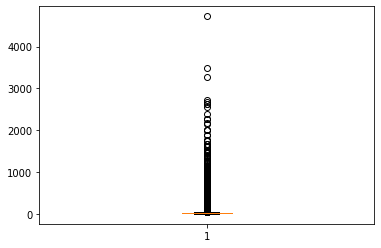

In [6]:
fig, ax = plt.subplots()
x = np.concatenate(np.concatenate([NOTEEVENTS_DISCHARGE_NLP_DF_TEST['SEN_LEN_ARRAY']]))
ax.boxplot(x)
plt.show()

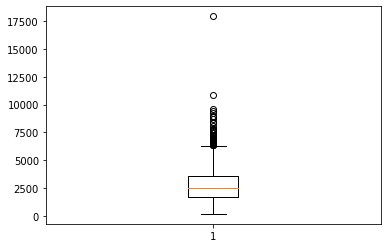

In [7]:
fig, ax = plt.subplots()
y = list(map(lambda x:x[4],NOTEEVENTS_DISCHARGE_NLP_DF_TEST['SEN_LEN_STAT']))
ax.boxplot(y)
plt.show()

In [8]:
stats.describe(x)

DescribeResult(nobs=207780, minmax=(1, 4727), mean=26.78038791028973, variance=2728.8559473321866, skewness=21.086968739098594, kurtosis=918.1003236455407)

In [9]:
stats.describe(y)

DescribeResult(nobs=2000, minmax=(168, 17936), mean=2782.2145, variance=2208818.6117956475, skewness=1.520326954466363, kurtosis=6.705293153935305)

In [10]:
len(set(x))

775

In [11]:
import math
max_words = int(3*math.sqrt(2081202.326139175)+2740)
max_sentences = int(0.5*math.sqrt(2403.8499834242816)+26)
print('max_words = '+str(max_words))
print('max_sentences = '+str(max_sentences))
print('word/sentence = '+str(int(max_words/max_sentences)))

max_words = 7067
max_sentences = 50
word/sentence = 141


In [4]:
NOTEEVENTS_DISCHARGE_NLP_DF_TEST=None

In [5]:
#I mistakingly included 102 for sentence seperator but my sentences are prety short and now I want to replace 102 with 119 which is the token for '.'
def replace_token(x):
    x_list = []
    for i in x:
        if i == 102:
            x_list.append(119)
        else:
            x_list.append(i)
    return x_list
        
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT_CORRECTED'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT']\
                                        .transform(lambda x:replace_token(x[1:]))

### 3.2 Prepare the tokens in a MATRIX for BERT

In [6]:
def create_matrix(x):
    max_word = 128
    max_sent = 30
    x = x[:max_word*max_sent]
    sent_LIST = [101]
    matrix_LIST = []
    counter = 1
    for i in x:
        if counter%(max_word-1)==0:
            sent_LIST.append(102)
            matrix_LIST.append(sent_LIST)
            sent_LIST = [101]
        else:
            sent_LIST.append(i)
        counter = counter + 1
    l = len(sent_LIST)
    if l>1:
        sent_LIST.append(102)
        sent_LIST.extend(np.zeros(max_word-l-1).astype(int))
        matrix_LIST.append(sent_LIST)
    return matrix_LIST

In [7]:
NOTEEVENTS_DISCHARGE_NLP_DF['TEXT_BERT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT_CORRECTED'].transform(lambda x:create_matrix(x))

In [8]:
def attention_mask(x):
    max_word = 128
    sent_len = len(x)
    attention_mask = []
    for i in range(0,sent_len-1):
        attention_mask.append(np.ones(max_word).astype(int).tolist())
    last_sent = []
    for i in x[-1]:
        if i == 0:
            last_sent.append(0)
        else:
            last_sent.append(1)
    attention_mask.append(last_sent)
    return attention_mask

NOTEEVENTS_DISCHARGE_NLP_DF['ATTENTION_MASK_BERT'] = NOTEEVENTS_DISCHARGE_NLP_DF['TEXT_BERT']\
                                                    .transform(lambda x:attention_mask(x))

In [9]:
NOTEEVENTS_DISCHARGE_NLP_DF['HADM_ID'] = NOTEEVENTS_DISCHARGE_NLP_DF.index.values
NOTEEVENTS_DISCHARGE_NLP_DF['SENTENCE_LEN'] = NOTEEVENTS_DISCHARGE_NLP_DF['ATTENTION_MASK_BERT'].transform(lambda x:len(x))

In [10]:
#NOTE_DISCHARGE_NLP_LABEL_DF.to_csv('C:/Users/kfpj179/Desktop/Final Project/data/NOTE_DISCHARGE_NLP_LABEL.csv', 
#                                   index=False,header=True)

### 3.4 Query BERT model to retrun embeddings

In [11]:
#NOTE_DISCHARGE_NLP_LABEL_DF = pd.read_csv('C:/Users/kfpj179/Desktop/Final Project/data/NOTE_DISCHARGE_NLP_LABEL.csv', 
#                            sep=',', header = 0).astype({'HADM_ID': 'str','TEXT_BERT':'object'})
#NOTE_DISCHARGE_NLP_LABEL_DF['TEXT_BERT'] = NOTE_DISCHARGE_NLP_LABEL_DF['TEXT_BERT']\
#                                            .transform(lambda x:literal_eval(x))
#NOTE_DISCHARGE_NLP_LABEL_DF['ATTENTION_MASK_BERT'] = NOTE_DISCHARGE_NLP_LABEL_DF['ATTENTION_MASK_BERT']\
#                                            .transform(lambda x:literal_eval(x))

In [12]:
#NOTE_DISCHARGE_NLP_DF = NOTEEVENTS_DISCHARGE_NLP_DF[['HADM_ID','SENTENCE_LEN','TEXT_BERT','ATTENTION_MASK_BERT']].copy()

In [13]:
NOTE_DISCHARGE_NLP_LABEL_NP = NOTEEVENTS_DISCHARGE_NLP_DF[['HADM_ID','SENTENCE_LEN','TEXT_BERT','ATTENTION_MASK_BERT']]\
.to_numpy()

In [14]:
embeddings = {}
a = 0
for i in NOTE_DISCHARGE_NLP_LABEL_NP:
    tokens = torch.tensor(i[2])
    attention_mask = torch.tensor(i[3])
    embeddings[i[0]] = np.array(model(tokens,attention_mask)[0].data)
    a = a + 1
    print(a)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [28]:
TEXT_EMBEDDINGS_DF = pd.DataFrame.from_dict(embeddings, orient='index', columns = ['EMBEDDINGS'])

In [34]:
TEXT_EMBEDDINGS_DF = TEXT_EMBEDDINGS_DF.join(NOTEEVENTS_DISCHARGE_NLP_DF[['TEXT_BERT']],how='left')

Batch of 10 Admissions:
<li>256 tokens and maximum 27 rows took 106 seconds</li>
<li>128 tokens and maximum 54 rows took 47 seconds</li>
Batch of 20 Admissions:
<li>256 tokens and maximum 27 rows took 164 seconds</li>
<li>128 tokens and maximum 54 rows took 161 seconds</li>